In [11]:
include("notebook_examples.jl");

In [2]:
function solve(problem, q, τ_s, τ_a)
    # Choose an end time such that we can be certain that a steady state solution
    # has been found before terminating
    t_end = 100.0
    Δt = LatticeBoltzmann.delta_t(problem)
    n_steps = round(Int, t_end / Δt)

    process_method = TrackHydrodynamicErrors(
        problem,
        false,
        n_steps,
        LatticeBoltzmann.VelocityConvergenceStoppingCriteria(1E-7, problem)
    )

    collision_model = LatticeBoltzmann.TRT(
        τ_s,
        τ_a,
        (x_idx, y_idx, t) -> LatticeBoltzmann.lattice_force(problem, x_idx, y_idx, t)
    )

    result = LatticeBoltzmann.simulate(
        problem,
        q,
        t_end = t_end,
        should_process = false,
        collision_model = collision_model,
        process_method = process_method,
        initialization_strategy = ZeroVelocityInitialCondition(),
    )

    return result
end


function main(quadratures = [D2Q9()], scale = 2, τ_s_range = range(0.51, stop = 10.0, step = 0.01), τ_a_range = τ_s_range)
    with_logger(TerminalLogger(stderr, Logging.Warn)) do
        s = []
        for q in quadratures
            @showprogress "Computing optimal relaxation times..." for τ_s in τ_s_range, τ_a in τ_a_range

                ν = (τ_s - 0.5) / q.speed_of_sound_squared
                problem = PoiseuilleFlow(ν, scale)

                result = solve(problem, q, τ_s, τ_a)
                errors = result.processing_method.df[end]

                push!(s, (
                    τ_s = τ_s,
                    τ_a = τ_a,
                    quadrature = q,
                    error_u = errors.error_u,
                    error_p = errors.error_p,
                    error_σ_xx = errors.error_σ_xx,
                    error_σ_xy = errors.error_σ_xy
                ))
            end
        end
        return s
    end
end

main (generic function with 5 methods)

In [3]:
τs = range(0.51, stop = 10.0, step=0.1)
τs = range(0.51, stop = 10.0, step=0.1)
results = main([D2Q9()], 1, τs, τs)
DataFrame(results)

Computing optimal relaxation times...100%|██████████████| Time: 3:00:05m05


,τ_s,τ_a,quadrature,error_u,error_p,error_σ_xx,error_σ_xy
,Float64,Float64,D2Q9…,Float64,Float64,Float64,Float64
1,0.51,0.51,"""D2Q9""",0.0564042,2.17858e-9,Inf,0.00110982
2,0.51,0.52,"""D2Q9""",0.0563752,4.29308e-9,Inf,0.00111002
3,0.51,0.53,"""D2Q9""",0.0563462,6.49923e-9,Inf,0.00111022
4,0.51,0.54,"""D2Q9""",0.0563172,8.72279e-9,Inf,0.00111042
5,0.51,0.55,"""D2Q9""",0.0562882,1.09492e-8,Inf,0.00111062
6,0.51,0.56,"""D2Q9""",0.0562592,1.31739e-8,Inf,0.00111082
7,0.51,0.57,"""D2Q9""",0.0562302,1.53948e-8,Inf,0.00111101
8,0.51,0.58,"""D2Q9""",0.0562012,1.76112e-8,Inf,0.00111121
9,0.51,0.59,"""D2Q9""",0.0561722,1.98225e-8,Inf,0.00111141


In [4]:
# @save "trt_magic_parameter_001.jld2" results

In [3]:
τs = range(0.51, stop = 10.0, step=0.01)
τs = range(0.51, stop = 10.0, step=0.01)
@load "trt_magic_parameter_001.jld2"

1-element Array{Symbol,1}:
 :results

In [13]:
τ_as = map(d -> d.τ_a, results) |> unique;
τ_ss = map(d -> d.τ_s, results) |> unique;
result_by_taus = map(results) do r
    (r.τ_s, r.τ_a) => r.error_u
end |> Dict;

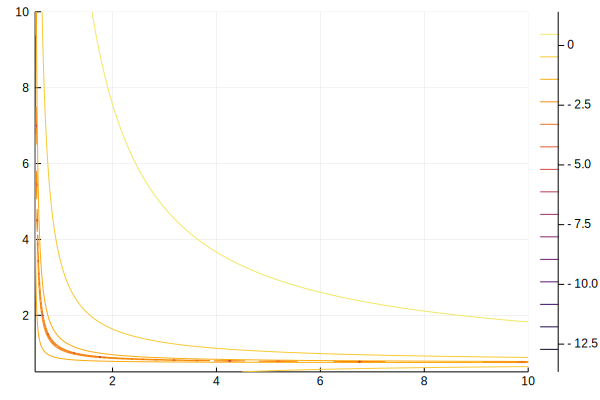

In [8]:
contour(τ_ss, τ_as, ((a, b) -> result_by_taus[(a, b)] |> log10))

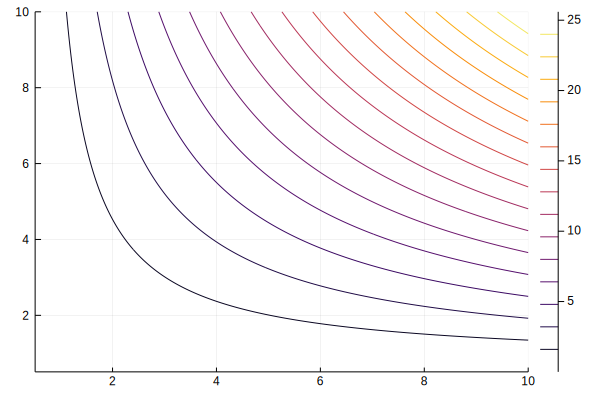

In [10]:
contour(τ_ss, τ_as, ((a, b) -> result_by_taus[(a, b)]))

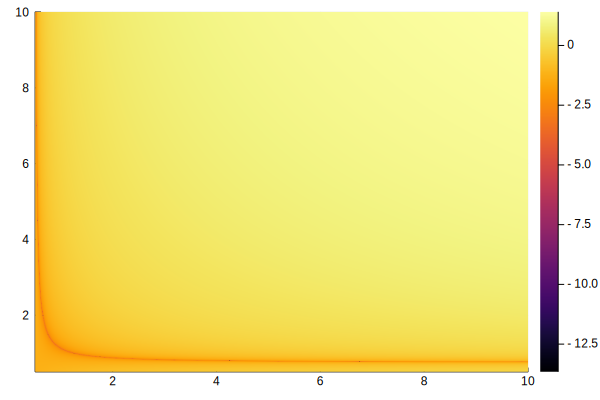

In [17]:
#heatmap(τ_ss, τ_as, ((a, b) -> result_by_taus[(a, b)] |> log10), scale=:log10)
heatmap(τ_ss, τ_as, ((a, b) -> result_by_taus[(a, b)] |> log10))